# 电商数据分析


## 数据集介绍

巴西电子商务平台 Olist Store从2016年至2018年之间10万多条的真实订单交易数据(脱敏)。
 
- 数据集来源：[Kaggle 公开数据集](https://www.kaggle.com/olistbr/brazilian-ecommerce)
- 该数据集包含9张表

表名 | 说明
-|-
olist_customers_dataset.csv | 客户及其位置的信息
olist_geolocation_dataset.csv |巴西邮政编码及其纬度/经度坐标信息
olist_Order Items Dataset.csv|每个订单中购买的商品的数据
olist_Payments Dataset.csv|订单付款的数据
olist_Order Reviews Dataset.csv|客户所做评论的数据
olist_Order Dataset.csv|订单交易数据
olist_Products Dataset.csv|Olist销售的产品的数据
olist_Sellers Dataset.csv| Olist完成订单的卖家的数据。
product_Category Name Translation.csv|将商品名从葡萄牙语翻译为英语

各表之间的关系如下：

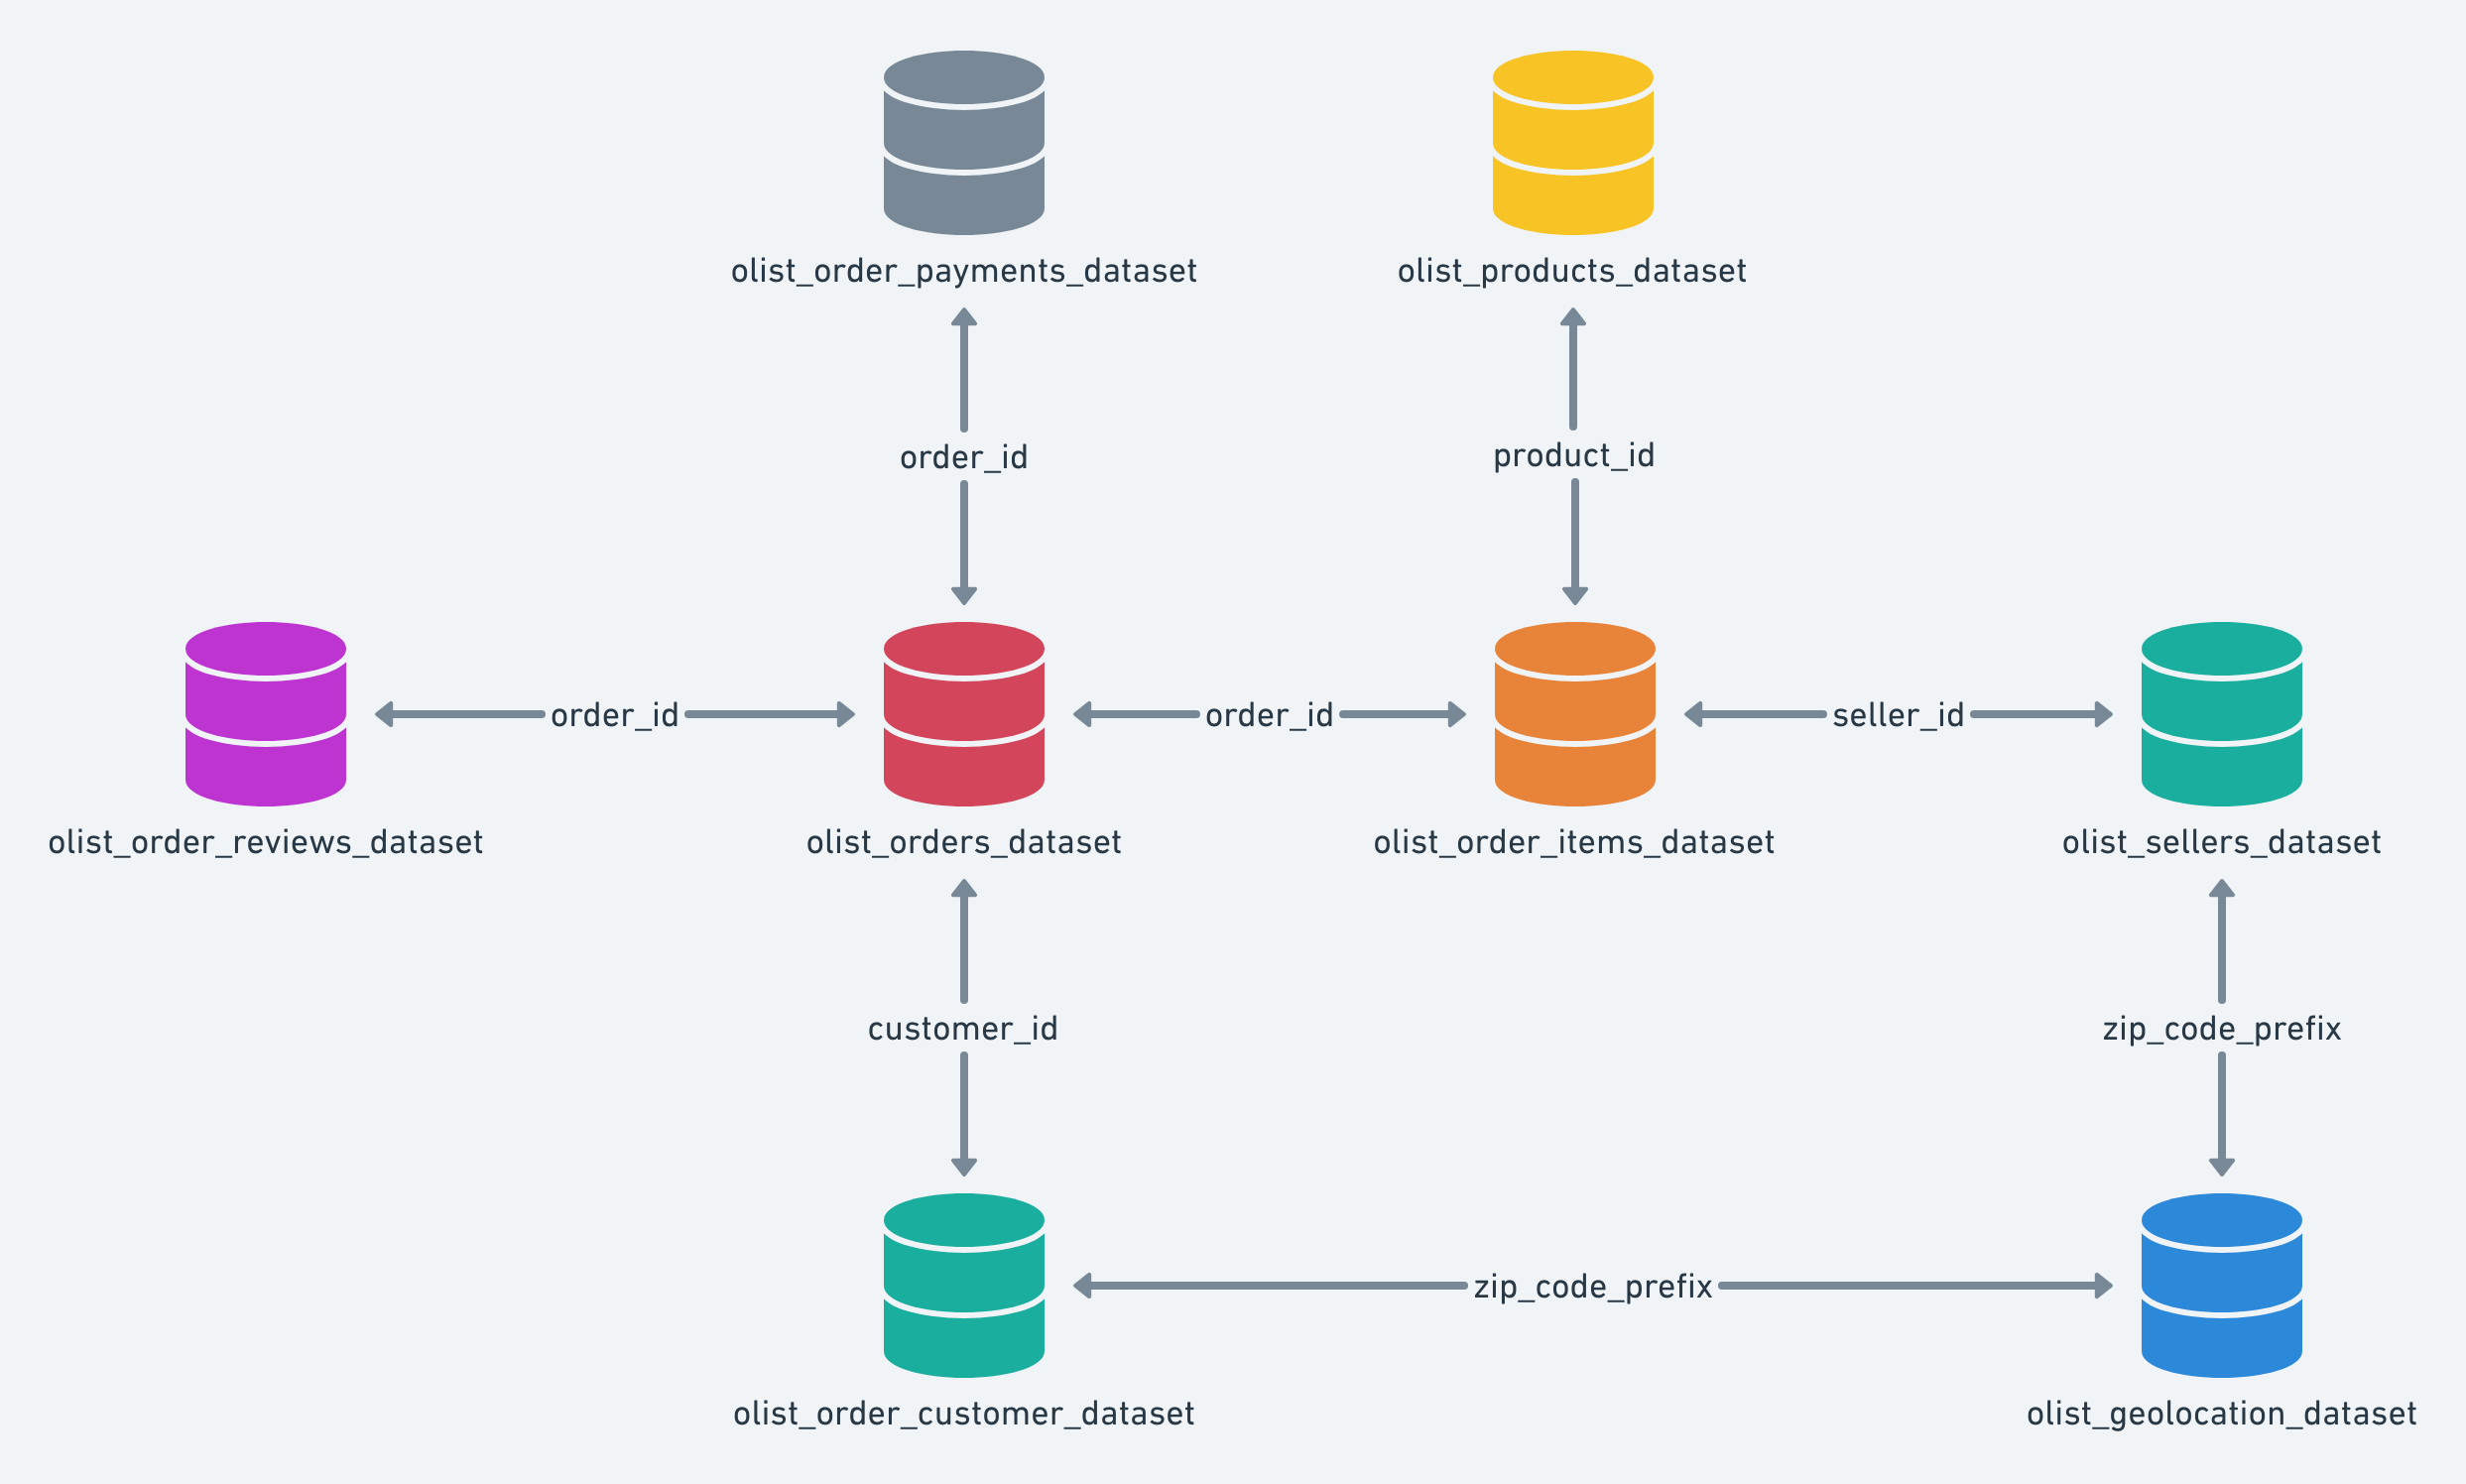

由于数据包含了2016-09-15到2018-08-29之间的订单数据，而2016和2018这两年数据并不完整，因此这里仅对**2017一整个年度的数据**进行分析。

## 导入相关库

In [298]:
import numpy as np  # 科学计算工具包
import pandas as pd  # 数据分析工具包
import matplotlib.pyplot as plt # 图表绘制工具包
import seaborn as sns # 基于 matplot, 导入 seaborn 会修改默认的 matplotlib 配色方案和绘图样式，这会提高图表的可读性和美观性
import os 
import pymysql
from sqlalchemy import create_engine # 数据库

# 在 jupyter notebook 里面显示图表
%matplotlib inline 

## 获取数据集

In [299]:
# 目录下所有 CSV 文件
table_list= [filename for filename in os.listdir('.') if filename.endswith('.csv') ]
print(table_list)

['olist_sellers_dataset.csv', 'sale_data.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'review_data.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']


In [300]:
# 获取数据集
orders = pd.read_csv("olist_orders_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
seller = pd.read_csv("olist_sellers_dataset.csv")
geo = pd.read_csv("olist_geolocation_dataset.csv")
pro_trans = pd.read_csv("product_category_name_translation.csv")

## 理解数据集

通过预览数据，了解所有字段和其含义。

字段 | 说明
-|-
product_id|商品ID
seller_id|商家ID
order_id|订单ID
customer_id|订单对应的用户ID（每个订单有一个唯一的customer_id）
order_status|订单状态
order_purchase_timestamp|下单时间
order_approved_at|付款审批时间
order_delivered_carrier_date|快递揽收日期
order_delivered_customer_date|订单送达日期
order_estimated_delivery_date|预计送达日期
customer_unique_id|客户唯一标识符
customer_zip_code_prefix|客户邮政编码前5位
customer_city|客户所在城市
customer_state|客户所在的州
review_id|评论ID
review_score|评价得分，客户在满意度调查中给出的注释范围为1到5。
review_comment_title|评论标题（葡萄牙语）
review_comment_message|评论内容（葡萄牙语）
review_creation_date|发出满意度调查日期
review_answer_timestamp|客户满意度回复日期
payment_sequential|付款序列(客户可以使用多种付款方式支付同一个订单）
payment_type|付款方式
payment_installments|分期付款期数
payment_value|交易金额
order_item_id|序号，用于标识同一订单中包含的商品数量。 
price|商品价格
freight_value|单个商品的运费（如果订单包含多个商品，总运费平摊到每个商品中）
shipping_limit_date|显示将订单处理到物流合作伙伴的卖家发货限制日期
seller_zip_code_prefix|卖家邮政编码前5位
seller_city|卖家所在城市
seller_state|卖家所在州 
product_category_name|产品品类名称（葡萄牙语）
product_category_name_english|产品品类名称（英语）
product_name_lenght|产品名称长度
product_description_lenght|产品说明长度
product_photos_qty|产品照片数量
product_weight_g|产品重量单位g
product_length_cm|产品长度单位cm
product_height_cm|产品高度单位cm
product_width_cm|产品宽度单位cm

## 总体运营指标分析

- 订单量
- 销售额
- 客单价

### 合并数据集

根据需要分析的指标，选定对应表，并进行合并

表名|说明
-|-
olist_Order Dataset.csv|订单交易数据
olist_Order Items Dataset.csv|每个订单中购买的商品的数据
olist_customers_dataset.csv | 客户及其位置的信息

In [301]:
# 合并数据集
res = pd.merge(orders,order_items, on='order_id',how='left')
sale_data = pd.merge(res,customers, on='customer_id',how='left')
print('合并后数据集所有字段\n',sale_data.columns.values)
print('==='*15)

# 选取子集
sale_data = sale_data[['order_id','order_item_id','customer_unique_id','product_id','seller_id','price','freight_value','order_status','order_purchase_timestamp','order_approved_at','order_delivered_customer_date',
                    'order_estimated_delivery_date','customer_city','customer_state']]
sale_data.info()

合并后数据集所有字段
 ['order_id' 'customer_id' 'order_status' 'order_purchase_timestamp'
 'order_approved_at' 'order_delivered_carrier_date'
 'order_delivered_customer_date' 'order_estimated_delivery_date'
 'order_item_id' 'product_id' 'seller_id' 'shipping_limit_date' 'price'
 'freight_value' 'customer_unique_id' 'customer_zip_code_prefix'
 'customer_city' 'customer_state']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   order_item_id                  112650 non-null  float64
 2   customer_unique_id             113425 non-null  object 
 3   product_id                     112650 non-null  object 
 4   seller_id                      112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value              

各个字段说明如下

字段 | 说明
-|-
order_id|订单ID
customer_unique_id|客户唯一标识符
order_item_id|序号，用于标识同一订单中包含的商品数量
product_id|商品ID
seller_id|商家ID
price|商品价格
freight_value|单个商品的运费（如果订单包含多个商品，总运费平摊到每个商品中）
order_status|订单状态
order_purchase_timestamp|下单时间
order_approved_at|付款审批时间
order_delivered_customer_date|订单送达日期
order_estimated_delivery_date|预计送达日期
customer_city|客户所在城市
customer_state|客户所在的州

### 清洗数据集

In [302]:
# 预览数据集
sale_data.head()

,order_id,order_item_id,customer_unique_id,product_id,seller_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,1.0,af07308b275d755c9edb36a90c618231,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,1.0,3a653a41f6f9fc3d2a113cf8398680e8,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04 00:00:00,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,1.0,7c142cf63193a1473d2e66489a9ae977,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,45.00,27.20,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15 00:00:00,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,1.0,72632f0f9dd73dfee390c9b22eb56dd6,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,19.90,8.72,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26 00:00:00,santo andre,SP


In [303]:
# 统计缺失值数量和占比
def missing_info(data,num):
# data: dataframe类型
# num: 数字类型，显示前几行数据
# return: 缺失值统计\占比

    null_data = data.isnull().sum().sort_values(ascending=False)
    percent_1 = data.isnull().sum()/data.isnull().count()
    missing_data = pd.concat([null_data,percent_1.apply(lambda x: format(x, '.2%'))],axis=1,keys=['total missing','missing percentage'])
    print(missing_data.head(num))

missing_info(sale_data,10)

                               total missing missing percentage
order_delivered_customer_date           3229              2.85%
freight_value                            775              0.68%
price                                    775              0.68%
seller_id                                775              0.68%
product_id                               775              0.68%
order_item_id                            775              0.68%
order_approved_at                        161              0.14%
customer_state                             0              0.00%
customer_city                              0              0.00%
order_estimated_delivery_date              0              0.00%


缺失值处理：

- order_delivered_customer_date 字段缺失值数量为3229，相对其他缺失数据较多，但是与整体数据相比较少，可选择删除缺失值。
- freight_value、price、seller_id、product_id、order_item_id、order_approved_at 的缺失值与整体数据相比就更少了，亦可删除。

In [304]:
# 删除缺失值
sale_data = sale_data.dropna()
sale_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110181 entries, 0 to 113424
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       110181 non-null  object 
 1   order_item_id                  110181 non-null  float64
 2   customer_unique_id             110181 non-null  object 
 3   product_id                     110181 non-null  object 
 4   seller_id                      110181 non-null  object 
 5   price                          110181 non-null  float64
 6   freight_value                  110181 non-null  float64
 7   order_status                   110181 non-null  object 
 8   order_purchase_timestamp       110181 non-null  object 
 9   order_approved_at              110181 non-null  object 
 10  order_delivered_customer_date  110181 non-null  object 
 11  order_estimated_delivery_date  110181 non-null  object 
 12  customer_city                 

In [305]:
# 观察数据异常情况
sale_data.describe()

,order_item_id,price,freight_value
count,110181.000000,110181.000000,110181.000000
mean,1.198210,119.977353,19.948667
std,0.706723,182.308639,15.699156
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.900000,16.260000
75%,1.000000,134.170000,21.150000
max,21.000000,6735.000000,409.680000


In [306]:
# 去重处理
sale_data = sale_data.drop_duplicates()
sale_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110181 entries, 0 to 113424
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       110181 non-null  object 
 1   order_item_id                  110181 non-null  float64
 2   customer_unique_id             110181 non-null  object 
 3   product_id                     110181 non-null  object 
 4   seller_id                      110181 non-null  object 
 5   price                          110181 non-null  float64
 6   freight_value                  110181 non-null  float64
 7   order_status                   110181 non-null  object 
 8   order_purchase_timestamp       110181 non-null  object 
 9   order_approved_at              110181 non-null  object 
 10  order_delivered_customer_date  110181 non-null  object 
 11  order_estimated_delivery_date  110181 non-null  object 
 12  customer_city                 

In [307]:
# 转化格式

def transform_datetime(data,column_list):
    for i in column_list:
        data[i] = pd.to_datetime(data[i])
    print('日期时间字段转化完成')
    
data = sale_data
column_list =['order_purchase_timestamp','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date'] 
transform_datetime(data,column_list)

日期时间字段转化完成


数据清洗后
- 样本大小：110181 条数据
- 字段：14个
- 无异常值,无重复值
- 有少量缺失值，已删除

### 导出到 mysql 数据库

In [308]:
def export_mysql(data,user,password,host_port,db,table_name):
    # data: Dataframe 类型
    # user: 用户名
    # password: 密码
    # host_port: 主机，端口
    # db: 数据库名
    # table_name: 表名

    print('将清洗后的数据导出到 mysql')
    engine = create_engine("mysql+pymysql://{}:{}@{}/{}".format(user, password, host_port, db))
    con = engine.connect()#创建连接
    data.to_sql(table_name,engine,if_exists='replace',index=False)
    print('成功导出')
    
data = sale_data
user = 'root'
password = '1234567890'
host_port = '127.0.0.1:3306'
db = 'test'
table_name = 'sale_data'

export_mysql(data,user,password,host_port,db,table_name)

将清洗后的数据导出到 mysql
成功导出


**由于数据包含了2016-09-15到2018-08-29之间的订单数据，而2016和2018这两年数据并不完整，因此这里对2017一整个年度的数据进行分析。如无注明，以下各个部分的指标分析均使用2017年的数据。**

In [309]:
print(sale_data['order_purchase_timestamp'].max())
print(sale_data['order_purchase_timestamp'].min())

2018-08-29 15:00:37
2016-09-15 12:16:38


### 数据分析

#### 获取2017年的数据

In [314]:
# 新增日期字段、年份、月份字段
sale_data['order_date'] = sale_data['order_purchase_timestamp'].dt.date
sale_data['order_year'] = sale_data['order_purchase_timestamp'].dt.year
sale_data['order_month'] = sale_data['order_purchase_timestamp'].dt.month

# 获取年份为2017年的数据
sale_data_17 = sale_data.loc[sale_data['order_year']==2017].copy()
sale_data_17.head()

,order_id,order_item_id,customer_unique_id,product_id,seller_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,order_date,order_year,order_month
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,sao paulo,SP,2017-10-02,2017,10
3,949d5b44dbf5de918fe9c16f97b45f8a,1.0,7c142cf63193a1473d2e66489a9ae977,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,45.00,27.20,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15,sao goncalo do amarante,RN,2017-11-18,2017,11
5,a4591c265e18cb1dcee52889e2d8acc3,1.0,80bb27c7c16e8f973207a5086ab329e2,060cb19345d90064d1015407193c233d,8581055ce74af1daba164fdbd55a40de,147.90,27.36,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-26 10:57:55,2017-08-01,congonhinhas,PR,2017-07-09,2017,7
7,6514b8ad8028c9f2cc2374ded245783f,1.0,932afa1e708222e5821dac9cd5db4cae,4520766ec412348b8d4caa5e8a18c464,16090f2ca825584b5a147ab24aa30c86,59.99,15.17,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-26 12:55:51,2017-06-07,nilopolis,RJ,2017-05-16,2017,5
8,76c6e866289321a7c93b82b54852dc33,1.0,39382392765b6dc74812866ee5ee92a7,ac1789e492dcd698c5c10b97a671243a,63b9ae557efed31d1f7687917d248a8d,19.90,16.05,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-02-02 14:08:10,2017-03-06,faxinalzinho,RS,2017-01-23,2017,1


#### 年订单量

In [315]:
order_number = sale_data_17['order_id'].nunique()
print('2017年订单量: {}'.format(order_number))

2017年订单量: 43412


#### 年销售金额

##### 如何计算订单金额？

例子：
order_id=00143d0f86d6fbd9f9b38ab440ac16f5 有3件商品（相同产品）。每件商品的运费根据其尺寸和重量计算。要得到每个订单的总运费值，您只需将其相加即可。

order_id | order_item_id| price|freight_value
-|-|-|-
00143d0f86d6fbd9f9b38ab440ac16f5|1| 21.33|15.10
00143d0f86d6fbd9f9b38ab440ac16f5|2| 21.33|15.10
00143d0f86d6fbd9f9b38ab440ac16f5|3| 21.33|15.10

- 总产品价格：21.33 * 3 = 63.99
- 总运费：15.10 * 3 = 45.30
- 订单总额（产品+运费）：45.30+63.99=109.29

##### 如何计算销售额？

销售额是指支付订单总金额，需要剔除取消订单金额、拒收订单金额、退货订单金额等无效订单金额

由于订单状态只有一种：delivered(已送达)，销售额就等于所有订单金额的总和

In [316]:
# 订单状态
print('订单状态种类：',sale_data_17['order_status'].unique())

# 按 order_id 对数据进行分组,计算出每个订单的总额
total_sale = sale_data_17.groupby("order_id").sum()['price']+ sale_data_17.groupby(["order_id"]).sum()['freight_value']
print('2017年销售金额:',total_sale.sum())
# 也等于 price 字段的总和加上 freight_value字段的总和
items_price = sale_data_17['price'].sum()
freight = sale_data_17['freight_value'].sum()
print('2017年销售金额:',items_price+freight)

订单状态种类： ['delivered']
2017年销售金额: 6919251.81
2017年销售金额: 6919251.8100000005


#### 客单价

In [317]:
total_customers = sale_data_17['customer_unique_id'].nunique()
print('2017年消费总人数',total_customers)
avg_trans = total_sale.sum()/total_customers
print('2017年客单价：',avg_trans)

2017年消费总人数 42121
2017年客单价： 164.27083426319413


- 2017年整体销售表现
    - 2017年销售金额和订单数量整体呈上升趋势，11月销售金额和订单数量达到顶峰，且远高于其他月份，1月销售金额最低，3,5月达到了阶段性的小高峰；总的来说，后半年的表现远好于前半年。

- 2017年每日销售金额和订单数量趋势 
  - 11月24日网站销售金额暴涨，订单数量破千，结合上图可知11月的销售金额高很大程度是24日这天造成的，分析原因可从外部和外部找起，当天是否是当地的节日或者发生重大庆祝事件，电商平台是否开展了年末促销活动等。
  
- 2017年顾客大致分布情况
    - 平台顾客大部分来自于 圣保罗州(SP)、米纳斯吉拉斯州(MG)、巴拉那州(PR)三个州

## 销售类指标分析

产品层面

- 各品类贡献销售金额分布
- 子类
- 销量前十的品类

- 销售金额
- 客单价

### 合并数据集

根据需要分析的指标，选定对应表，并进行合并

表名|说明
-|-
olist_Order Dataset.csv|订单交易数据
olist_Order Items Dataset.csv|每个订单中购买的商品的数据
olist_Products Dataset.csv|Olist销售的产品的数据
product_category_name_english|产品品类名称（英语）

In [318]:
# 合并数据集
res = pd.merge(orders,order_items, on='order_id',how='left')
res1 = pd.merge(res,products, on='product_id',how='left')
pro_data = pd.merge(res1,pro_trans, on='product_category_name',how='left')
print('合并后数据集所有字段\n',pro_data.columns.values)
print('==='*15)

# 选取子集
pro_data = pro_data[['order_id','order_item_id','product_id','product_category_name_english','seller_id','price','freight_value','order_status','order_purchase_timestamp','order_approved_at','order_delivered_customer_date',
                    'order_estimated_delivery_date']]
pro_data.info()

合并后数据集所有字段
 ['order_id' 'customer_id' 'order_status' 'order_purchase_timestamp'
 'order_approved_at' 'order_delivered_carrier_date'
 'order_delivered_customer_date' 'order_estimated_delivery_date'
 'order_item_id' 'product_id' 'seller_id' 'shipping_limit_date' 'price'
 'freight_value' 'product_category_name' 'product_name_lenght'
 'product_description_lenght' 'product_photos_qty' 'product_weight_g'
 'product_length_cm' 'product_height_cm' 'product_width_cm'
 'product_category_name_english']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   order_item_id                  112650 non-null  float64
 2   product_id                     112650 non-null  object 
 3   product_category_name_english  111023 non-null  object 
 4   seller_id             

字段 | 说明
-|-
order_id|订单ID
order_item_id|序号，用于标识同一订单中包含的商品数量
product_id|商品ID
product_category_name|产品品类
seller_id|商家ID
price|商品价格
freight_value|单个商品的运费（如果订单包含多个商品，总运费平摊到每个商品中）
order_status|订单状态
order_purchase_timestamp|下单时间
order_approved_at|付款审批时间
order_delivered_customer_date|订单送达日期
order_estimated_delivery_date|预计送达日期

### 清洗数据集

各个字段说明如下

In [319]:
# 预览数据集
pro_data.head()

,order_id,order_item_id,product_id,product_category_name_english,seller_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,87285b34884572647811a353c7ac498a,housewares,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,1.0,595fac2a385ac33a80bd5114aec74eb8,perfumery,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,1.0,aa4383b373c6aca5d8797843e5594415,auto,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,66922902710d126a0e7d26b0e3805106,45.00,27.20,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,1.0,65266b2da20d04dbe00c5c2d3bb7859e,stationery,2c9e548be18521d1c43cde1c582c6de8,19.90,8.72,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26 00:00:00


In [320]:
# 统计缺失值数量和占比

missing_info(pro_data,10)

                               total missing missing percentage
order_delivered_customer_date           3229              2.85%
product_category_name_english           2402              2.12%
freight_value                            775              0.68%
price                                    775              0.68%
seller_id                                775              0.68%
product_id                               775              0.68%
order_item_id                            775              0.68%
order_approved_at                        161              0.14%
order_estimated_delivery_date              0              0.00%
order_purchase_timestamp                   0              0.00%


缺失值处理：

- order_delivered_customer_date 和 product_category_name_english 字段缺失值数量为3229和2402，相对其他缺失数据较多，但是与整体数据相比较少，可选择删除缺失值。
- freight_value、price、seller_id、product_id、order_item_id、order_approved_at 的缺失值与整体数据相比就更少了，亦可删除。

In [321]:
# 删除缺失值
pro_data = pro_data.dropna()
pro_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108623 entries, 0 to 113424
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       108623 non-null  object 
 1   order_item_id                  108623 non-null  float64
 2   product_id                     108623 non-null  object 
 3   product_category_name_english  108623 non-null  object 
 4   seller_id                      108623 non-null  object 
 5   price                          108623 non-null  float64
 6   freight_value                  108623 non-null  float64
 7   order_status                   108623 non-null  object 
 8   order_purchase_timestamp       108623 non-null  object 
 9   order_approved_at              108623 non-null  object 
 10  order_delivered_customer_date  108623 non-null  object 
 11  order_estimated_delivery_date  108623 non-null  object 
dtypes: float64(3), object(9)
memor

In [322]:
# 观察数据异常情况
pro_data.describe()

,order_item_id,price,freight_value
count,108623.000000,108623.000000,108623.000000
mean,1.198641,120.078689,19.982812
std,0.708589,182.071226,15.734174
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.900000,16.290000
75%,1.000000,134.900000,21.160000
max,21.000000,6735.000000,409.680000


In [323]:
# 去重处理
pro_data = pro_data.drop_duplicates()
pro_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108623 entries, 0 to 113424
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       108623 non-null  object 
 1   order_item_id                  108623 non-null  float64
 2   product_id                     108623 non-null  object 
 3   product_category_name_english  108623 non-null  object 
 4   seller_id                      108623 non-null  object 
 5   price                          108623 non-null  float64
 6   freight_value                  108623 non-null  float64
 7   order_status                   108623 non-null  object 
 8   order_purchase_timestamp       108623 non-null  object 
 9   order_approved_at              108623 non-null  object 
 10  order_delivered_customer_date  108623 non-null  object 
 11  order_estimated_delivery_date  108623 non-null  object 
dtypes: float64(3), object(9)
memor

In [324]:
# 转化格式

data = pro_data
column_list =['order_purchase_timestamp','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date'] 
transform_datetime(data,column_list)

日期时间字段转化完成


数据清洗后
- 样本大小：108623 条数据
- 字段：12个
- 无异常值,无重复值
- 有少量缺失值，已删除

### 导出到 mysql 数据库

In [325]:
data = pro_data
table_name = 'pro_data'
export_mysql(data,user,password,host_port,db,table_name)

将清洗后的数据导出到 mysql
成功导出


## 客户类


### 客户购物行为偏好
    - 付款方式偏好
    - 时间段偏好

#### 合并相关数据集

根据需要分析的指标，选定对应表，并进行合并

表名|说明
-|-
olist_Order Dataset.csv|订单交易数据
olist_Payments Dataset.csv|订单付款数据
olist_customers_dataset.csv|客户及其位置的信息

In [326]:
# 合并数据集
res = pd.merge(orders,customers, on='customer_id',how='left')
customer_data = pd.merge(res,payments,on='order_id',how='left')
print('合并后数据集所有字段\n',customer_data.columns.values)
print('==='*15)
# 选取子集
customer_data = customer_data[['order_id','customer_unique_id','order_status','order_purchase_timestamp','order_approved_at','payment_sequential','payment_type','payment_installments','payment_value']]
customer_data.info()
print('==='*15)

合并后数据集所有字段
 ['order_id' 'customer_id' 'order_status' 'order_purchase_timestamp'
 'order_approved_at' 'order_delivered_carrier_date'
 'order_delivered_customer_date' 'order_estimated_delivery_date'
 'customer_unique_id' 'customer_zip_code_prefix' 'customer_city'
 'customer_state' 'payment_sequential' 'payment_type'
 'payment_installments' 'payment_value']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 103887 entries, 0 to 103886
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  103887 non-null  object 
 1   customer_unique_id        103887 non-null  object 
 2   order_status              103887 non-null  object 
 3   order_purchase_timestamp  103887 non-null  object 
 4   order_approved_at         103712 non-null  object 
 5   payment_sequential        103886 non-null  float64
 6   payment_type              103886 non-null  object 
 7   payment_installments    

各个字段说明如下

字段 | 说明
-|-
order_id|订单ID
customer_unique_id|客户唯一标识符
order_status|订单状态
order_purchase_timestamp|下单时间
order_approved_at | 付款审批时间
payment_sequential|付款序列(客户可以使用多种付款方式支付同一个订单）
payment_type|付款方式
payment_installments|分期付款期数
payment_value|交易金额

### 清洗数据集

In [327]:
# 预览数据集
customer_data.head()

,order_id,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,1.0,credit_card,3.0,179.12


In [328]:
# 统计缺失值数量和占比

missing_info(customer_data,10)

                          total missing missing percentage
order_approved_at                   175              0.17%
payment_value                         1              0.00%
payment_installments                  1              0.00%
payment_type                          1              0.00%
payment_sequential                    1              0.00%
order_purchase_timestamp              0              0.00%
order_status                          0              0.00%
customer_unique_id                    0              0.00%
order_id                              0              0.00%


缺失值处理：

- order_approved_at字段缺失值数量为175，只占整体数据0.17%，可选择删除缺失值。
- payment_sequential、payment_value、payment_installments、payment_type 的缺失值与整体数据相比就更少了，亦可删除。

In [329]:
# 删除缺失值
customer_data = customer_data.dropna()
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103711 entries, 0 to 103886
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  103711 non-null  object 
 1   customer_unique_id        103711 non-null  object 
 2   order_status              103711 non-null  object 
 3   order_purchase_timestamp  103711 non-null  object 
 4   order_approved_at         103711 non-null  object 
 5   payment_sequential        103711 non-null  float64
 6   payment_type              103711 non-null  object 
 7   payment_installments      103711 non-null  float64
 8   payment_value             103711 non-null  float64
dtypes: float64(3), object(6)
memory usage: 7.9+ MB


In [330]:
# 观察数据异常情况
customer_data.describe()

,payment_sequential,payment_installments,payment_value
count,103711.000000,103711.000000,103711.000000
mean,1.092362,2.854750,154.002395
std,0.705805,2.687422,217.009306
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.795000
max,29.000000,24.000000,13664.080000


异常值情况

- payment_installments 最小值为0
    + 付款要么一次性付清，要么分期付款，而分期付款一般有3、6、12、24期等。
    + 分期付款期数为1时，说明用户是一次性付清，没有分期。所以这里为0是异常值

- payment_value 最小值为0
    + 支付金额为0的情况有点异常，但不排除是使用代金券或者礼品卡。需要查询详细数据。

In [331]:
# 查询异常值的详细数据 payment_installments

customer_data[customer_data['payment_installments']==0]

,order_id,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,payment_sequential,payment_type,payment_installments,payment_value
66607,744bade1fcf9ff3f31d860ace076d422,f54cea27c80dc09bfe07b1cf1e01b845,delivered,2018-04-22 11:34:42,2018-04-24 19:04:46,2.0,credit_card,0.0,58.69
69303,1a57108394169c0b47d8f876acc9ba2d,9925e1d7dff0d807355599dee04830ab,delivered,2018-05-15 16:25:14,2018-05-15 16:36:52,2.0,credit_card,0.0,129.94


可以看出，异常数据的支付金额不为0，并使用借记卡进行支付，但分期付款期数为0，明显矛盾，删除这类异常值

In [332]:
# 查询异常值的详细数据 payment_installments

customer_data[customer_data['payment_value']==0]

,order_id,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,payment_sequential,payment_type,payment_installments,payment_value
447,45ed6e85398a87c253db47c2d9f48216,e4000306cf2f63714e6bb70dd20a6592,delivered,2017-06-08 21:18:45,2017-06-08 21:30:18,3.0,voucher,1.0,0.0
27104,fa65dad1b0e818e3ccc5cb0e39231352,8af7ac63b2efbcbd88e5b11505e8098a,shipped,2017-04-20 12:45:34,2017-04-22 09:10:13,14.0,voucher,1.0,0.0
27113,fa65dad1b0e818e3ccc5cb0e39231352,8af7ac63b2efbcbd88e5b11505e8098a,shipped,2017-04-20 12:45:34,2017-04-22 09:10:13,13.0,voucher,1.0,0.0
33797,6ccb433e00daae1283ccc956189c82ae,677ad9cdca6c47c733f0cc6e23d7bb4c,delivered,2017-10-26 23:51:35,2017-10-27 00:46:58,4.0,voucher,1.0,0.0
89601,b23878b3e8eb4d25a158f57d96331b18,9077449283dc1319d5e51fb3159b28e2,delivered,2017-05-27 19:20:24,2017-05-27 19:35:17,4.0,voucher,1.0,0.0
101282,8bcbe01d44d147f901cd3192671144db,cc5aa1b8337e394da54980226bb0f6d4,delivered,2018-01-24 23:24:14,2018-01-24 23:37:20,4.0,voucher,1.0,0.0


可以看到，异常数据的支付方式是代金券，印证了之前的想法，说明这类数据不属于异常值

处理异常值

异常数据加起来一共2条，可根据 index 删除

In [333]:
# 删除异常值
customer_data=customer_data.drop(index=customer_data[customer_data['payment_installments']==0].index)
customer_data.describe()

,payment_sequential,payment_installments,payment_value
count,103709.000000,103709.000000,103709.000000
mean,1.092345,2.854805,154.003546
std,0.705801,2.687418,217.011184
min,1.000000,1.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.800000
max,29.000000,24.000000,13664.080000


In [334]:
# 去重处理
customer_data = customer_data.drop_duplicates()
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103709 entries, 0 to 103886
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  103709 non-null  object 
 1   customer_unique_id        103709 non-null  object 
 2   order_status              103709 non-null  object 
 3   order_purchase_timestamp  103709 non-null  object 
 4   order_approved_at         103709 non-null  object 
 5   payment_sequential        103709 non-null  float64
 6   payment_type              103709 non-null  object 
 7   payment_installments      103709 non-null  float64
 8   payment_value             103709 non-null  float64
dtypes: float64(3), object(6)
memory usage: 7.9+ MB


In [335]:
# 转化格式

data = customer_data
column_list =['order_purchase_timestamp','order_approved_at'] 
transform_datetime(data,column_list)

日期时间字段转化完成


数据清洗后
- 样本大小：103709条数据
- 字段：9个
- 有异常值，已删除
- 无重复值
- 有少量缺失值，已删除

### 导出到 mysql 数据库

In [336]:
data = customer_data
table_name = 'customer_data'
export_mysql(data,user,password,host_port,db,table_name)

将清洗后的数据导出到 mysql
成功导出


- 付款方式偏好

43658名客户中，付款方式首选信用卡 credit_card 支付，占比高达72.76%，其次是通过线下付款的方式 boleto(巴西主流的线下支付工具)，占比19.99%,代金券 voucher 和借记卡 debit_card 分别占比6.36%和0.89%。


- 购物时间段偏好

- 各时段客户下单数和支付金额分布
    - 顾客下单时间主要集中在早上9:00到晚上23:00。

- 工作日、周末订单数量情况
    工作日、周末客户下单数和支付金额分布
    - 工作日的订单表现优于周末

### 客户价值指标

由于这里涉及到新老客户指标，这里的数据使用2016年至2018年之间所有数据，并假定2016年为电商平台初始年份。

- 用户第一次消费（首购）
- 用户最后一次消费
- 新老客消费比
    - 多少用户仅消费了一次？
    - 每月新客户占比？
    - 用户分层 -RFM

#### 合并相关数据集

使用 sale_data 数据集，进行增减字段处理

In [337]:
# 获取每个订单的所有商品价格和运费

items_total = sale_data.groupby("order_id",as_index=False).sum()[["order_id","price","freight_value"]]

# 计算每个订单的总金额，增加新字段 order_total 
items_total['order_total'] = items_total.apply(lambda x:x["price"]+x["freight_value"],axis=1)

# 获取每个订单的商品数量
products_item = sale_data[["order_id","order_item_id"]].groupby("order_id",as_index=False).max()

# 将订单的信息合并，得到关于每个订单的信息
merged_info = pd.merge(items_total,products_item,on="order_id",how="left")

# 将 customer_unique_id 字段添加到订单信息中
order_info = pd.merge(merged_info,sale_data[["order_id","customer_unique_id","order_purchase_timestamp","order_status"]],on="order_id",how="left")
order_info.head()

# 为了助于理解，对字段进行更名处理
order_info.columns = ['order_id','items_total','items_freight', 'order_total','products_item','customer_unique_id','order_purchase_timestamp','order_status']


In [338]:
order_info.describe()

,items_total,items_freight,order_total,products_item
count,110181.000000,110181.000000,110181.000000,110181.000000
mean,152.177544,27.254938,179.432481,1.396420
std,255.850254,33.251492,271.335320,1.122887
min,0.850000,0.000000,9.590000,1.000000
25%,49.000000,14.290000,65.550000,1.000000
50%,91.200000,18.160000,114.330000,1.000000
75%,163.990000,29.190000,194.920000,1.000000
max,13440.000000,1794.960000,13664.080000,21.000000


用户平均每笔订单购买1个商品，中位数在1个商品，75分位数也在1个商品，说明绝大部分订单包含1各商品。最大值在21个，数字比较高。

平均订单价值 105.28

订单金额的情况差不多，大部分订单都集中在小额。一般来说，根据二八法则，20%的用户贡献的收入会占总收入的80%。

各个字段说明如下

字段 | 说明
-|-
order_id|订单ID
items_total|单个订单中所有商品的价格
items_freight|单个订单中所有商品的运费
order_total| 订单总金额(商品价格+运费)
products_item|单个订单中商品数量
customer_unique_id|客户唯一标识符
order_purchase_timestamp|下单时间
order_status|订单状态

### 清洗数据集

In [339]:
# 预览数据集
order_info.head()

,order_id,items_total,items_freight,order_total,products_item,customer_unique_id,order_purchase_timestamp,order_status
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,72.19,1.0,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,delivered
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,259.83,1.0,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,delivered
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,216.87,1.0,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,delivered
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,25.78,1.0,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,delivered
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,218.04,1.0,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,delivered


In [340]:
# 统计缺失值数量和占比

missing_info(order_info,10)

                          total missing missing percentage
order_status                          0              0.00%
order_purchase_timestamp              0              0.00%
customer_unique_id                    0              0.00%
products_item                         0              0.00%
order_total                           0              0.00%
items_freight                         0              0.00%
items_total                           0              0.00%
order_id                              0              0.00%


In [341]:
# 观察数据异常情况
order_info.describe()

,items_total,items_freight,order_total,products_item
count,110181.000000,110181.000000,110181.000000,110181.000000
mean,152.177544,27.254938,179.432481,1.396420
std,255.850254,33.251492,271.335320,1.122887
min,0.850000,0.000000,9.590000,1.000000
25%,49.000000,14.290000,65.550000,1.000000
50%,91.200000,18.160000,114.330000,1.000000
75%,163.990000,29.190000,194.920000,1.000000
max,13440.000000,1794.960000,13664.080000,21.000000


In [342]:
order_info['order_id'].nunique()

96462

In [343]:
# 去重处理
order_info = order_info.drop_duplicates()
order_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96462 entries, 0 to 110180
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  96462 non-null  object        
 1   items_total               96462 non-null  float64       
 2   items_freight             96462 non-null  float64       
 3   order_total               96462 non-null  float64       
 4   products_item             96462 non-null  float64       
 5   customer_unique_id        96462 non-null  object        
 6   order_purchase_timestamp  96462 non-null  datetime64[ns]
 7   order_status              96462 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 6.6+ MB


In [344]:
# 转化格式

data = order_info
column_list =['order_purchase_timestamp'] 
transform_datetime(data,column_list)

日期时间字段转化完成


数据清洗后
- 样本大小：96462 条数据
- 字段：8个
- 无异常值,无缺失值
- 有少量重复值，已删除

### 导出到 mysql 数据库

In [345]:
data = order_info
table_name = 'order_info'
export_mysql(data,user,password,host_port,db,table_name)

将清洗后的数据导出到 mysql
成功导出


### 数据分析

- 客户第一次消费（首购）
- 客户最后一次消费
- 新老客消费比
    - 多少用户仅消费了一次？
    - 每月新客户占比？
    - 用户分层 -RFM

In [346]:
order_info['order_status'].unique()

array(['delivered', 'canceled'], dtype=object)

订单状态有两种，需要筛掉取消的订单

In [347]:
order_info = order_info.drop(index=order_info[order_info['order_status']=='canceled'].index)
order_info['order_status'].unique()

array(['delivered'], dtype=object)

In [348]:
order_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96456 entries, 0 to 110180
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  96456 non-null  object        
 1   items_total               96456 non-null  float64       
 2   items_freight             96456 non-null  float64       
 3   order_total               96456 non-null  float64       
 4   products_item             96456 non-null  float64       
 5   customer_unique_id        96456 non-null  object        
 6   order_purchase_timestamp  96456 non-null  datetime64[ns]
 7   order_status              96456 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 6.6+ MB


   #### 客户第一次消费时间

In [349]:
order_info.groupby('customer_unique_id',as_index=False).order_purchase_timestamp.min()

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42
...,...,...
93332,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36
93333,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56
93334,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16
93335,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41


#### 客户最后一次消费时间

In [369]:
order_info.groupby('customer_unique_id',as_index=False).order_purchase_timestamp.max()

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42
...,...,...
93332,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36
93333,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56
93334,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16
93335,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41


#### 新老客户占比分析

由于这里涉及到新老客户指标，这里的数据使用2016年至2018年之间所有数据，并假定2016年为电商平台初始年份。

取每个客户首次和最后一次购买时间

In [368]:
user_life = order_info.groupby('customer_unique_id',as_index=False).order_purchase_timestamp.agg([min,max])
user_life.head()

,min,max
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42


In [371]:
# 查询只进行过一次购买的客户数(新客户数)

(user_life['min'] == user_life['max']).value_counts()

True     90773
False     2564
dtype: int64

可以看出，平台大部分都是新客户，新老客户占比接近 35：1，可得出平台在留存工作方面没有到位。

#### 使用 RFM 模型对客户进行分群
- R: Recency 最近一次消费
- F: Frequence 消费频率
- M: Monetray 消费金额

In [372]:
order_info.head()

,order_id,items_total,items_freight,order_total,products_item,customer_unique_id,order_purchase_timestamp,order_status,order_purchase_datetime,order_date,order_year,order_month
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,72.19,1.0,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,delivered,2017-09-13 08:59:02,2017-09-13,2017,9
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,259.83,1.0,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,delivered,2017-04-26 10:53:06,2017-04-26,2017,4
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,216.87,1.0,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,delivered,2018-01-14 14:33:31,2018-01-14,2018,1
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,25.78,1.0,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,delivered,2018-08-08 10:00:35,2018-08-08,2018,8
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,218.04,1.0,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,delivered,2017-02-04 13:57:51,2017-02-04,2017,2


In [484]:
rfm_table=pd.pivot_table(order_info,index=["customer_unique_id"],values=['order_purchase_timestamp',"order_id","order_total"],aggfunc={"order_purchase_timestamp":"max","order_id":"count","order_total":"sum"})
rfm_table

,order_id,order_purchase_timestamp,order_total
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,27.19
0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,86.22
0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,43.62
0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08 21:00:36,2067.42
fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,84.58
ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,112.46


R值最近一次消费时间表示用户最近一次消费距离现在的时间，消费时间越近的客户价值越大。所以要将 order_purchase_timestamp 里面具体的日期变成R中的天数。

假设现在时间是数据中日期时间最大那天 

In [402]:
# 两个日期相减
rfm_table['R'] = (rfm_table['order_purchase_timestamp'].max() - rfm_table['order_purchase_timestamp'])
# 获取天数差
rfm_table['R'] = rfm_table['R'].map(lambda x:x.days) 
rfm_table['R'] 

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    111
0000b849f77a49e4a4ce2b2a4ca5be3f    114
0000f46a3911fa3c0805444483337064    536
0000f6ccb0745a6a4b88665a16c9f078    320
0004aac84e0df4da2b147fca70cf8255    287
                                   ... 
fffcf5a5ff07b0908bd4e2dbc735a684    446
fffea47cd6d3cc0a88bd621562a9d061    261
ffff371b4d645b6ecea244b27531430a    567
ffff5962728ec6157033ef9805bacc48    118
ffffd2657e2aad2907e67c3e9daecbeb    483
Name: R, Length: 93337, dtype: int64

再将 order_id 和 order_total 重命名为F、M

In [403]:
# 为了助于理解，对字段进行更名处理
rfm_table.rename(columns={"order_id":"F","order_total":"M"},inplace=True)
rfm_table.head()

,F,order_purchase_timestamp,M,R
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,141.90,111
0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,27.19,114
0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,86.22,536
0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,43.62,320
0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,196.89,287


In [408]:
rfm = rfm_table[["R","F","M"]]
rfm.head()

,R,F,M
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
0000f46a3911fa3c0805444483337064,536,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62
0004aac84e0df4da2b147fca70cf8255,287,1,196.89


建立 RFM 模型

- 设定基线：中位数

一般而言，消费类的数据呈现长尾分布，都是长尾形态。80%甚至90%以上都集中在低频低额区间，少数的用户贡献了收入的大头，俗称二八法则。采用平均数无法很好的体现数组的特性，长尾用户很容易被平均。

- 基线规则
    - 高于基线为1(高纬度)，
    - 低于基线为0(低纬度)。

- 注意

由于R值的大小和用户价值呈现反比，所以高于基线的时候算低纬度，低于基线时算高纬度。

In [414]:
rfm['r_quartile'] = pd.qcut(rfm['R'], 2, ['1','0'])
rfm['f_quartile'] = pd.qcut(rfm['F'], 2, ['0','1'])
rfm['m_quartile'] = pd.qcut(rfm['M'], 2, ['0','1'])

rfm.head()

ValueError: Bin edges must be unique: array([ 1.,  1., 15.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

[报错的原因](https://stackoverflow.com/questions/20158597/how-to-qcut-with-non-unique-bin-edges/29930255)：

records with the same value cannot go in different bins/quantiles.
这里F值为1的数据太多了，而有同样F值的数据不能划分到不同的区间去。因此报错

解决办法：
- 使用 pandas >= 0.20.0 有这个修复
- 使用pandas.cut
- 自定义分位数区间，使得每个区间有不同个数的值
- 使用DataFrame.rank(method='first')对你的数据进行排名。排名给数据框架中的每个元素分配了一个唯一的值（排名），同时保持了元素的顺序（除了相同的值，它们将按照它们在数组中出现的顺序进行排名，参见 method='first'）。这就解决了这个问题，但你可能会有相同的（排名前）值进入不同的量子，这可能是正确的或不正确的，这取决于你的意图。
    - Example:
        + pd.qcut(df, nbins) <-- this generates "ValueError: Bin edges must be unique"
    - Then use this instead:
        + `pd.qcut(df.rank(method='first'), nbins)`

观察R、F、M的分布情况，找到合适的基线对R、F、M 进行分层

In [422]:
rfm.describe()

,R,F,M
count,93337.000000,93337.000000,93337.000000
mean,236.904893,1.033417,165.169657
std,152.552478,0.209096,226.312163
min,0.000000,1.000000,9.590000
25%,113.000000,1.000000,63.010000
50%,218.000000,1.000000,107.780000
75%,345.000000,1.000000,182.510000
max,713.000000,15.000000,13664.080000


<Figure size 720x360 with 0 Axes>

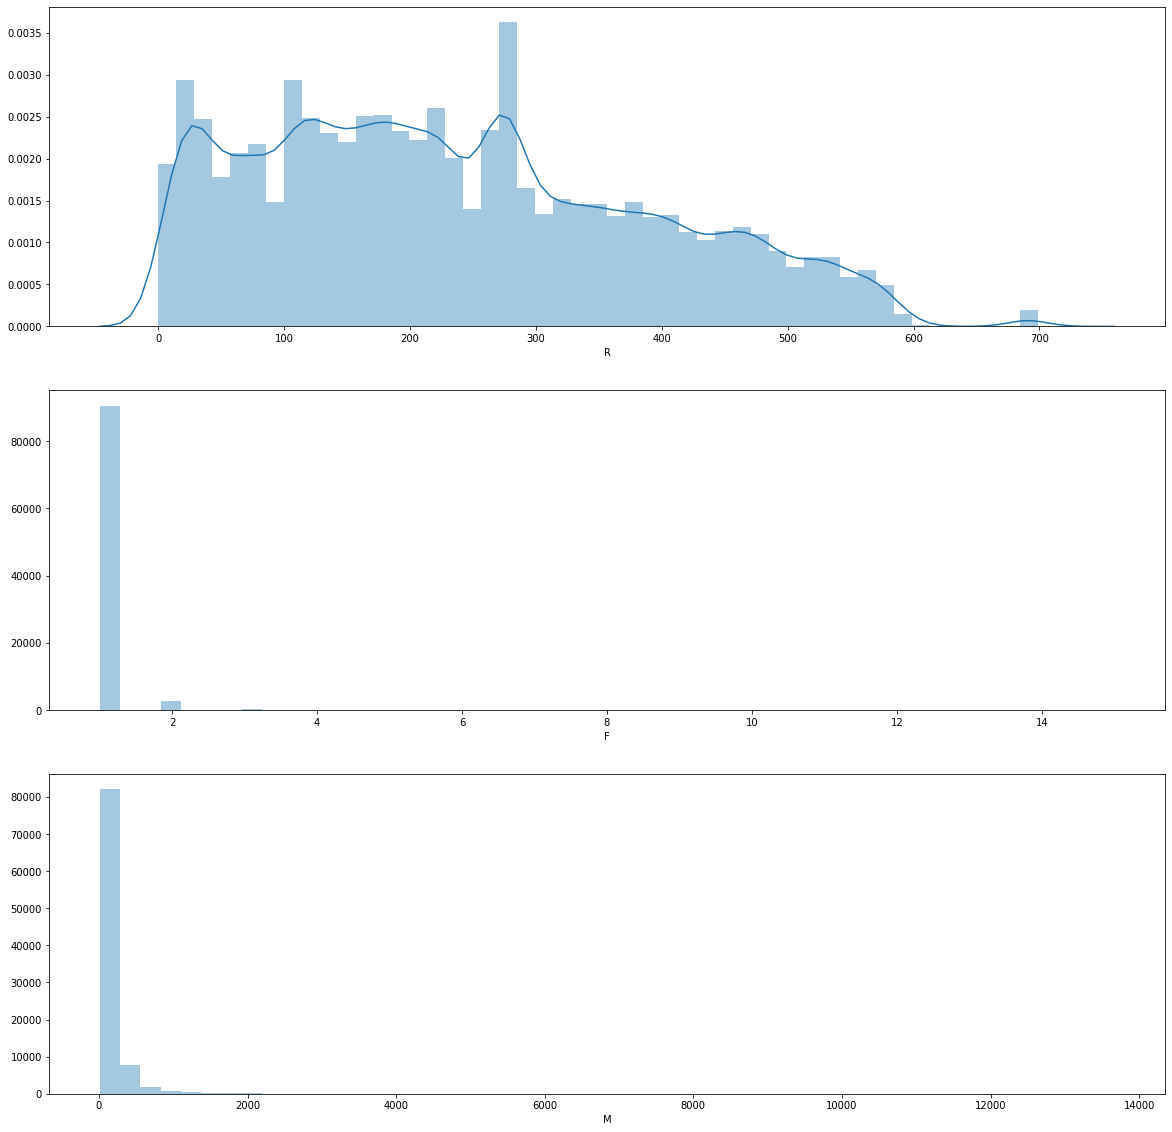

In [433]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

fig,axes=plt.subplots(3,1,figsize=(20, 20)) #创建一个一行三列的画布
sns.distplot(rfm['R'],ax=axes[0]) #左图
sns.distplot(rfm['F'],kde=False,ax=axes[1]) #中图
sns.distplot(rfm['M'],kde=False,ax=axes[2]) #右图

从上可得

- R值采用中位数进行划分
- F值存在很严重的偏态分布，F的数值大多集中在1，即消费频次只有1次，至少占整体75%,最大值为15。无法使用分位数方法来均分出2个等级，为了体现出区分度，这里使用自定义区间 bins= [1,15] 进行划分。
- M值存在很严重的偏态分布，75%的M数值小于182，最大值为 13664，这里使用四分之三位数进行划分。

修改 RFM 模型(三个指标的权重一致)

- R
    + 基线 
        - 中位数
    + 规则
        - 高于基线为0(低纬度)
        - 低于基线为1(高纬度)

- F
    + 基线
        - [1,15] 
    + 规则
        - 高于基线为1(高纬度)
        - 低于基线为0(低纬度)

- M
    + 基线
        - 四分位数
    + 规则
        - 高于基线为1(高纬度)
        - 低于基线为0(低纬度) 

In [443]:
# 对 R、F、M 划分

rfm['r_quartile'] = pd.qcut(rfm['R'], 2, labels=['1','0'])
rfm['f_quartile'] = pd.cut(rfm['F'], bins=[0,1,15], labels=['0','1'])
rfm['m_quartile'] = pd.qcut(rfm['M'], [0,0.75,1], labels=['0','1'])

rfm.head()

,R,F,M,r_quartile,f_quartile,m_quartile
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,1,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,1,0,0
0000f46a3911fa3c0805444483337064,536,1,86.22,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,0,0,0
0004aac84e0df4da2b147fca70cf8255,287,1,196.89,0,0,1


In [457]:
# 计算出 RFM 的总分

rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()

,R,F,M,r_quartile,f_quartile,m_quartile,RFM_Score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,1,0,0,100
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,1,0,0,100
0000f46a3911fa3c0805444483337064,536,1,86.22,0,0,0,000
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,0,0,0,000
0004aac84e0df4da2b147fca70cf8255,287,1,196.89,0,0,1,001


使用 RFM 模型将客户划分为8类：

重要价值客户、重要保持客户、重要发展客户、重要挽留客户、一般价值客户、一般保持客户、一般发展客户、一般挽留客户

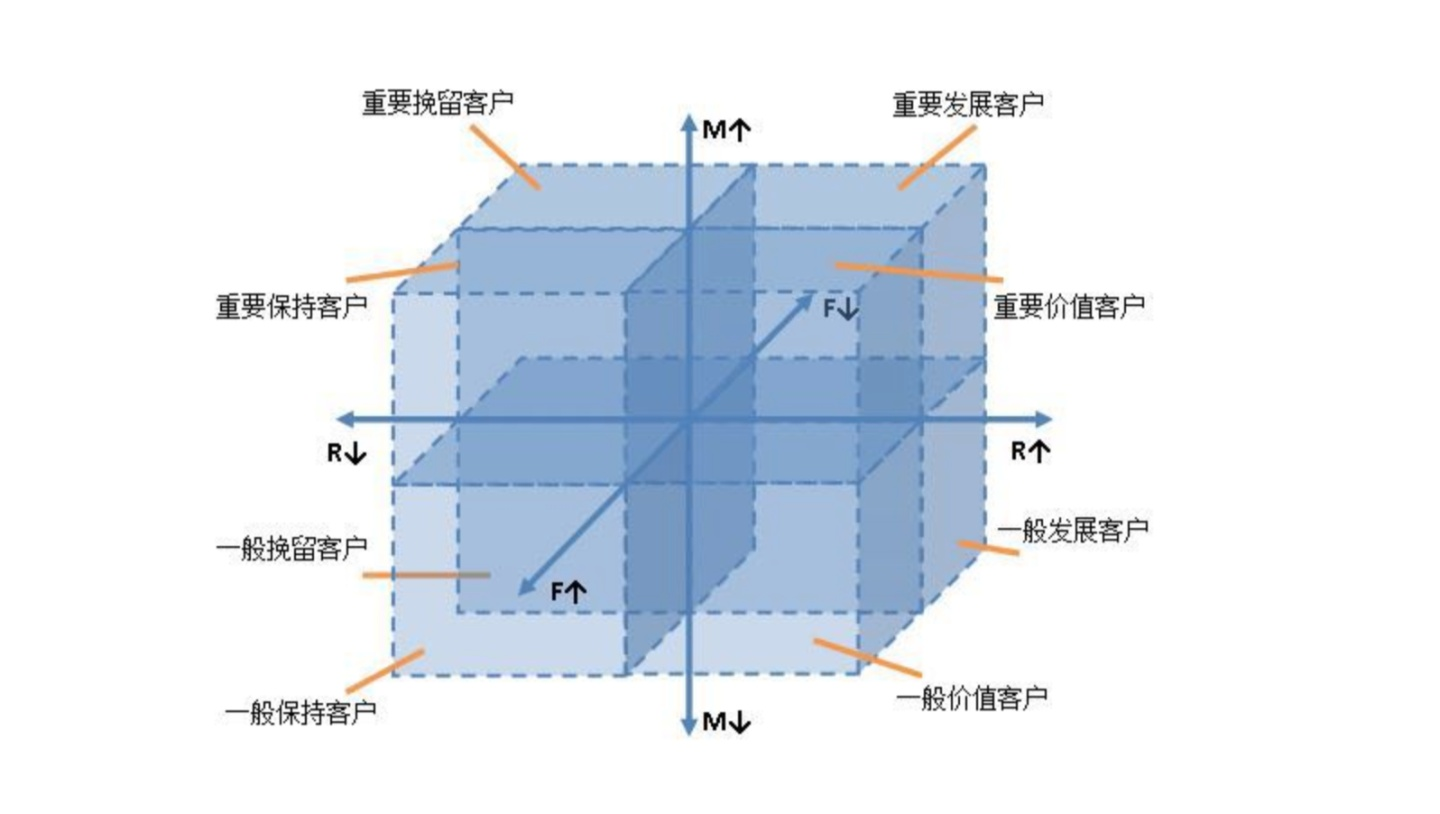



In [456]:
# 筛选出重要价值客户
rfm[rfm['RFM_Score']=='111'].sort_values('M', ascending=False).head()

,R,F,M,r_quartile,f_quartile,m_quartile,RFM_Score
customer_unique_id,,,,,,,
c8460e4251689ba205045f3ea17884a1,21,4,4655.88,1,1,1,111
eae0a83d752b1dd32697e0e7b4221656,126,2,2783.01,1,1,1,111
7b0eaf68a16e4808e5388c67345033c9,102,2,2340.08,1,1,1,111
6ddbc64bd04d40f7768ff088d94cbeb8,141,2,2299.66,1,1,1,111
906a8a4ec9f3d4c3e64fa6d1c4fe6009,40,2,2020.83,1,1,1,111


将 RFM 总分映射为客户八大类

RFM 总分 | 客户类别
-|-
111|重要价值客户
011|重要保持客户
101|重要发展客户
001|重要挽留客户
111|一般价值客户
011|一般保持客户
101|一般发展客户
001|一般挽留客户

In [463]:
customer_classification = {
"111":"重要价值客户",
"011":"重要保持客户",
"101":"重要发展客户",
"001":"重要挽留客户",
"110":"一般价值客户",
"010":"一般保持客户",
"100":"一般发展客户",
"000":"一般挽留客户",
}

rfm['customer_class'] = rfm['RFM_Score'].map(customer_classification)
rfm.head()

,R,F,M,r_quartile,f_quartile,m_quartile,RFM_Score,customer_class
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,1,0,0,100,一般发展客户
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,1,0,0,100,一般发展客户
0000f46a3911fa3c0805444483337064,536,1,86.22,0,0,0,000,一般挽留客户
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,0,0,0,000,一般挽留客户
0004aac84e0df4da2b147fca70cf8255,287,1,196.89,0,0,1,001,重要挽留客户


In [479]:
rfm['customer_class'].value_counts()

一般挽留客户    34586
一般发展客户    34388
重要发展客户    10904
重要挽留客户    10659
重要价值客户     1015
重要保持客户      756
一般价值客户      534
一般保持客户      495
Name: customer_class, dtype: int64

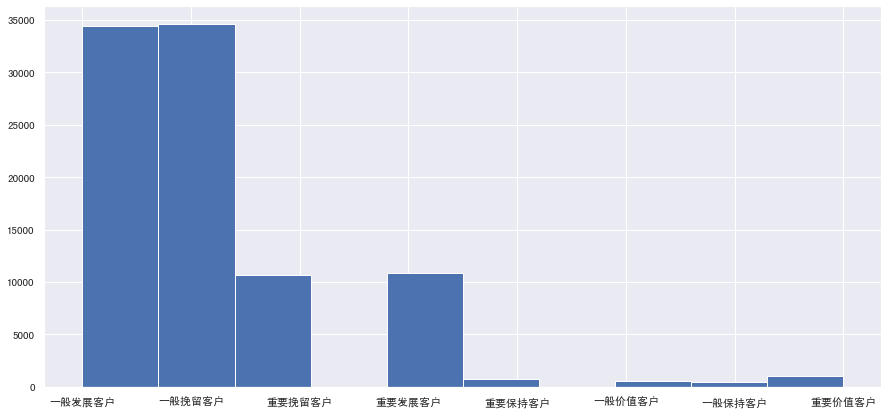

In [476]:
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题


rfm['customer_class'].hist(figsize=(15,7))

#### 导出到 mysql 数据库

In [478]:
data = rfm
table_name = 'RFM_data'
export_mysql(data,user,password,host_port,db,table_name)

将清洗后的数据导出到 mysql
成功导出


#### 2017年复购率
2017年内，每个客户消费次数统计

In [352]:
# 新增日期字段、年份、月份字段
order_info['order_date'] = order_info['order_purchase_timestamp'].dt.date
order_info['order_year'] = order_info['order_purchase_timestamp'].dt.year
order_info['order_month'] = order_info['order_purchase_timestamp'].dt.month

# 获取年份为2017年的数据
order_info_17 = order_info.loc[order_info['order_year']==2017].copy()
order_info_17.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43412 entries, 0 to 110179
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  43412 non-null  object        
 1   items_total               43412 non-null  float64       
 2   items_freight             43412 non-null  float64       
 3   order_total               43412 non-null  float64       
 4   products_item             43412 non-null  float64       
 5   customer_unique_id        43412 non-null  object        
 6   order_purchase_timestamp  43412 non-null  datetime64[ns]
 7   order_status              43412 non-null  object        
 8   order_purchase_datetime   43412 non-null  datetime64[ns]
 9   order_date                43412 non-null  object        
 10  order_year                43412 non-null  int64         
 11  order_month               43412 non-null  int64         
dtypes: datetime64[ns]

In [353]:
# 一年内客户消费次数
repurchase_info = order_info_17.groupby('customer_unique_id',as_index=False).count()[['customer_unique_id','order_purchase_timestamp']]
# 为了助于理解，对字段进行更名处理
repurchase_info.columns =['customer_unique_id','purchases']

# 复购次数 = 消费次数-1
repurchase_info['repurchases']= repurchase_info['purchases']-1
print(repurchase_info['purchases'].value_counts())
repurchase_info.head()


1    40952
2     1076
3       74
4       13
5        4
8        1
6        1
Name: purchases, dtype: int64


,customer_unique_id,purchases,repurchases
0,0000f46a3911fa3c0805444483337064,1,0
1,0000f6ccb0745a6a4b88665a16c9f078,1,0
2,0004aac84e0df4da2b147fca70cf8255,1,0
3,0005e1862207bf6ccc02e4228effd9a0,1,0
4,0006fdc98a402fceb4eb0ee528f6a8d4,1,0


复购率: 单位时间内(2017年内),消费1次以上的客户数占消费客户数

In [354]:
repurchase_rate = repurchase_info[repurchase_info['repurchases'] > 0].count()['customer_unique_id']/repurchase_info['customer_unique_id'].count()
print("2017年，消费客户数为{}人，复购用户数为{}人，复购率为{:.2%}".format(repurchase_info['customer_unique_id'].count(),repurchase_info[repurchase_info['repurchases'] > 0].count()['customer_unique_id'],repurchase_rate))


2017年，消费客户数为42121人，复购用户数为1169人，复购率为2.78%


## 风控类指标分析

- 参与满意度调查的顾客数
- 顾客满意度评分占比
- 顾客满意度调查完成天数
- 顾客满意度调查填写时间段

### 合并相关数据集

根据需要分析的指标，选定对应表，并进行合并

表名|说明
-|-
olist_Order Dataset.csv|订单交易数据
olist_Order Reviews Dataset.csv|客户所做评论的数据
olist_customers_dataset.csv|客户及其位置的信息

In [355]:
# 合并数据集
res = pd.merge(orders,customers, on='customer_id',how='left')
review_data = pd.merge(res,reviews, on='order_id',how='left')
print('合并后数据集所有字段\n',review_data.columns.values)
print('==='*15)

# 选取子集
review_data = review_data[['order_id','customer_unique_id','order_purchase_timestamp','review_id','review_score','review_creation_date','review_answer_timestamp','order_delivered_customer_date',
                    'order_estimated_delivery_date']]
review_data.info()

合并后数据集所有字段
 ['order_id' 'customer_id' 'order_status' 'order_purchase_timestamp'
 'order_approved_at' 'order_delivered_carrier_date'
 'order_delivered_customer_date' 'order_estimated_delivery_date'
 'customer_unique_id' 'customer_zip_code_prefix' 'customer_city'
 'customer_state' 'review_id' 'review_score' 'review_comment_title'
 'review_comment_message' 'review_creation_date' 'review_answer_timestamp']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   order_id                       100000 non-null  object
 1   customer_unique_id             100000 non-null  object
 2   order_purchase_timestamp       100000 non-null  object
 3   review_id                      100000 non-null  object
 4   review_score                   100000 non-null  int64 
 5   review_creation_date           100000 non-null  object
 6   

各个字段说明如下

字段 | 说明
-|-
order_id|订单ID
customer_unique_id|客户唯一标识符
order_purchase_timestamp|下单时间
order_delivered_customer_date|订单送达日期
order_estimated_delivery_date|预计送达日期
review_id|满意度调查ID
review_score|评价得分，1到5分(假设5分最好)
review_creation_date|发出满意度调查日期
review_answer_timestamp|客户满意度回复日期

### 清洗数据集

In [356]:
# 预览数据集
review_data.head()

,order_id,customer_unique_id,order_purchase_timestamp,review_id,review_score,review_creation_date,review_answer_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,2017-10-12 03:43:48,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,8d5266042046a06655c8db133d120ba5,4,2018-08-08 00:00:00,2018-08-08 18:37:50,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,e73b67b67587f7644d5bd1a52deb1b01,5,2018-08-18 00:00:00,2018-08-22 19:07:58,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,359d03e676b3c069f62cadba8dd3f6e8,5,2017-12-03 00:00:00,2017-12-05 19:21:58,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,e50934924e227544ba8246aeb3770dd4,5,2018-02-17 00:00:00,2018-02-18 13:02:51,2018-02-16 18:17:02,2018-02-26 00:00:00


In [357]:
# 统计缺失值数量和占比

missing_info(review_data,10)

                               total missing missing percentage
order_delivered_customer_date           2987              2.99%
order_estimated_delivery_date              0              0.00%
review_answer_timestamp                    0              0.00%
review_creation_date                       0              0.00%
review_score                               0              0.00%
review_id                                  0              0.00%
order_purchase_timestamp                   0              0.00%
customer_unique_id                         0              0.00%
order_id                                   0              0.00%


缺失值处理：

- order_delivered_customer_date 字段缺失值数量为2987，只占整体数据2.99%，可选择删除缺失值。

In [358]:
# 删除缺失值
review_data = review_data.dropna()
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97013 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       97013 non-null  object
 1   customer_unique_id             97013 non-null  object
 2   order_purchase_timestamp       97013 non-null  object
 3   review_id                      97013 non-null  object
 4   review_score                   97013 non-null  int64 
 5   review_creation_date           97013 non-null  object
 6   review_answer_timestamp        97013 non-null  object
 7   order_delivered_customer_date  97013 non-null  object
 8   order_estimated_delivery_date  97013 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.4+ MB


In [359]:
# 观察数据异常情况
review_data.describe()

,review_score
count,97013.000000
mean,4.142105
std,1.296684
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [360]:
# 去重处理
review_data = review_data.drop_duplicates()
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97013 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       97013 non-null  object
 1   customer_unique_id             97013 non-null  object
 2   order_purchase_timestamp       97013 non-null  object
 3   review_id                      97013 non-null  object
 4   review_score                   97013 non-null  int64 
 5   review_creation_date           97013 non-null  object
 6   review_answer_timestamp        97013 non-null  object
 7   order_delivered_customer_date  97013 non-null  object
 8   order_estimated_delivery_date  97013 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.4+ MB


In [361]:
# 转化格式

data = review_data
column_list =['order_purchase_timestamp','review_creation_date','review_answer_timestamp','order_delivered_customer_date','order_estimated_delivery_date'] 
transform_datetime(data,column_list)

日期时间字段转化完成


数据清洗后
- 样本大小：97013 条数据
- 字段：9个
- 无异常值,无重复值
- 有少量缺失值，已删除

### 导出到 mysql 数据库

In [362]:
data = review_data
table_name = 'review_data'
export_mysql(data,user,password,host_port,db,table_name)

将清洗后的数据导出到 mysql
成功导出


参与满意度调查的顾客数

顾客满意度评分占比

顾客满意度调查完成天数

顾客满意度调查填写时间段

发现

- 顾客对该电商平台满意度较高，好评率高达80%。
    + 以（1-2分：差评，3分：中评，4-5分：好评）为评价标准。参与满意度调查的顾客数一共有4,213名，其中评价5分占比最高，为58.78%，4分占比20.15%，好评率近80%，用户满意度较高；但1分和2分合计占比12.4%左右，平台还有一定的提高空间。
- 满意度调查发布3天内，回收率达 85.8%
    + 大部分顾客会在调查发布当天或者隔1-3天填写并提交
    + 1-3天内未填写的顾客，大概率会遗忘，调查回收最长可达 518 天
- 上午10时至下午14时、晚上21时至第二天凌晨1点这两个时间段是顾客完成调查的高峰期

建议

- 为了，提高调查回收率，建议调查发布1周后，提醒未填写的用户
- 可选择在上午10时至下午14时、晚上21时至第二天凌晨1点这两个时间段发布满意度调查或者提醒尚未填写的顾客